## <center> Практическое задание к лекции №5

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline

import random

from sklearn import datasets
from sklearn import model_selection

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import time
import datetime

**1.** Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.  

---

In [ ]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
    return forest

In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Сгенерируем датасет

In [ ]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=1000,
    n_features = 2, 
    n_informative = 2, 
    n_classes = 2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    random_state=None
)

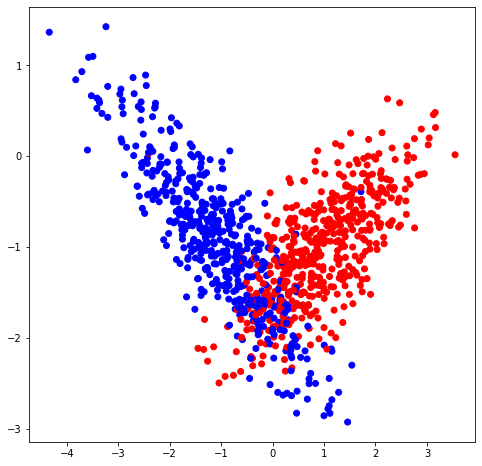

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [ ]:
# Разобьем выборку на обучающую и тестовую


train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 14)

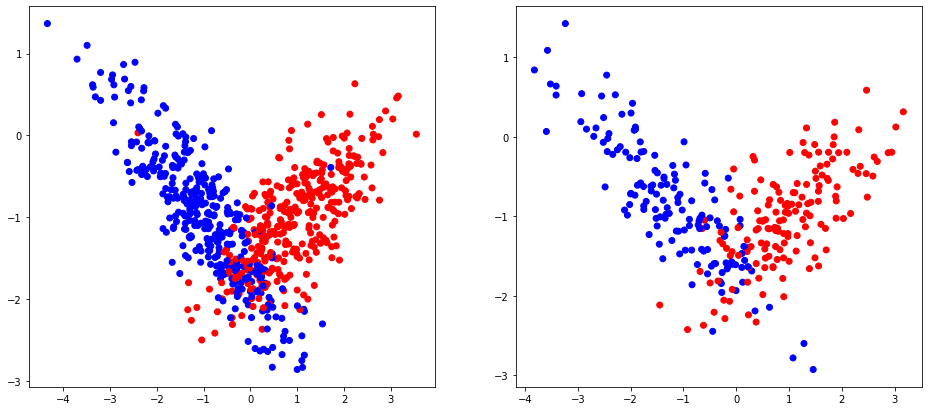

In [ ]:
# визуализируем данные трейна и теста

plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)

plt.subplot(1,2,2)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.show()

оформим функции для визуализации отчетов

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

In [ ]:
SUMMARY_DATA=[] #глобальная переменная для сохранения результата

def make_experiment(train_data, train_labels, test_data, test_labels, n_trees):
    global SUMMARY_DATA

    start_time = time.time()

    my_forest=random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)

    finish_time = time.time()    
    time_spent = datetime.timedelta(seconds=(finish_time - start_time)) 

    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
        
    plt.figure(figsize = (16, 7))
        
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) 
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Деревьев: {n_trees}\nTrain accuracy={train_accuracy:.2f}')
        
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Деревьев: {n_trees}\nTest accuracy={test_accuracy:.2f}')
        
    SUMMARY_DATA.append([n_trees, train_accuracy, test_accuracy, time_spent])
    

Построим лес из одного дерева

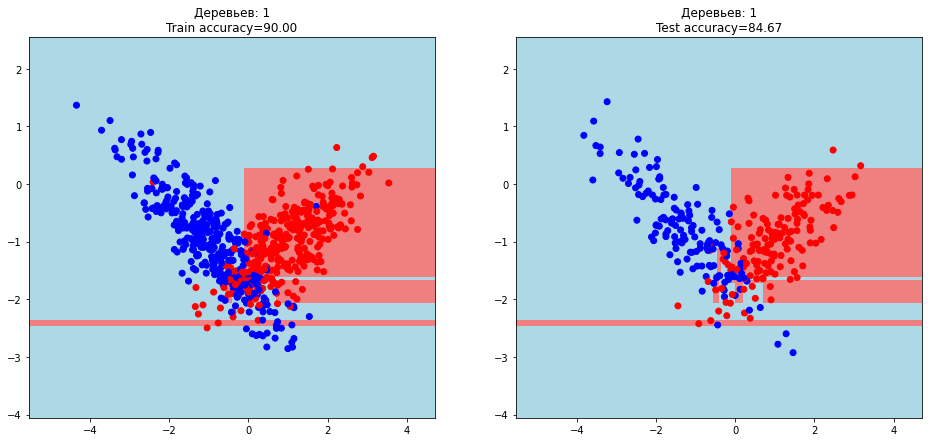

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 1)

Из трёх

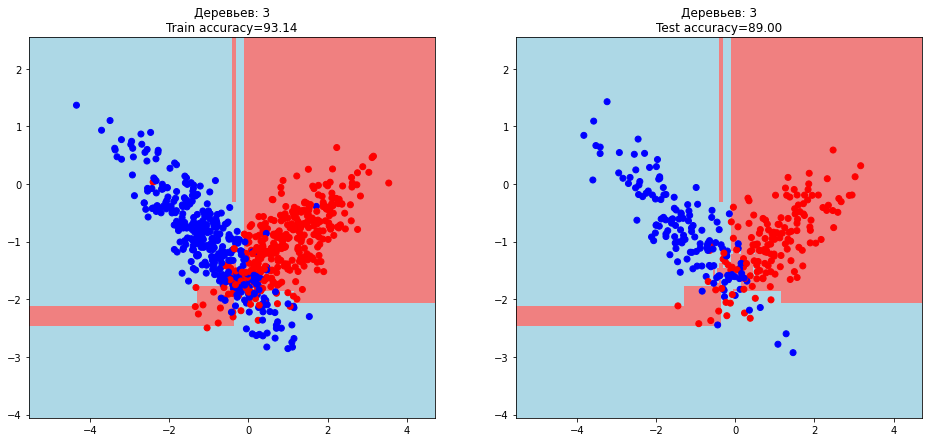

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 3)

из 10

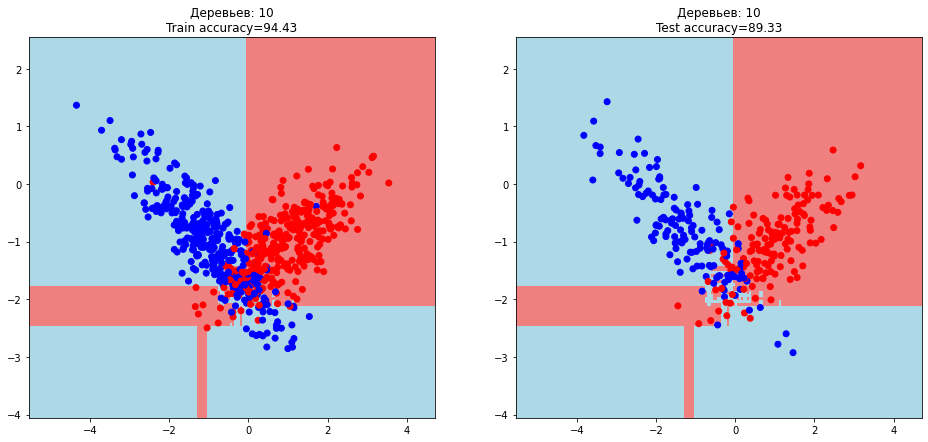

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 10)

из 50

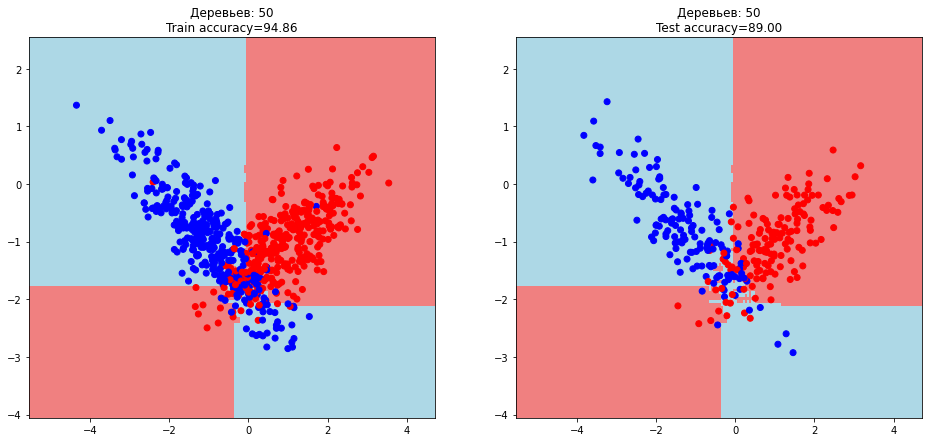

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 50)

из 100

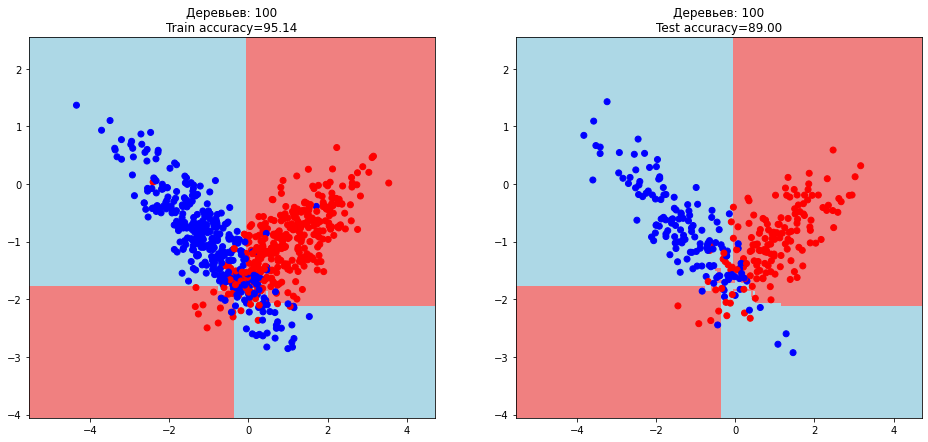

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 100)

из 200

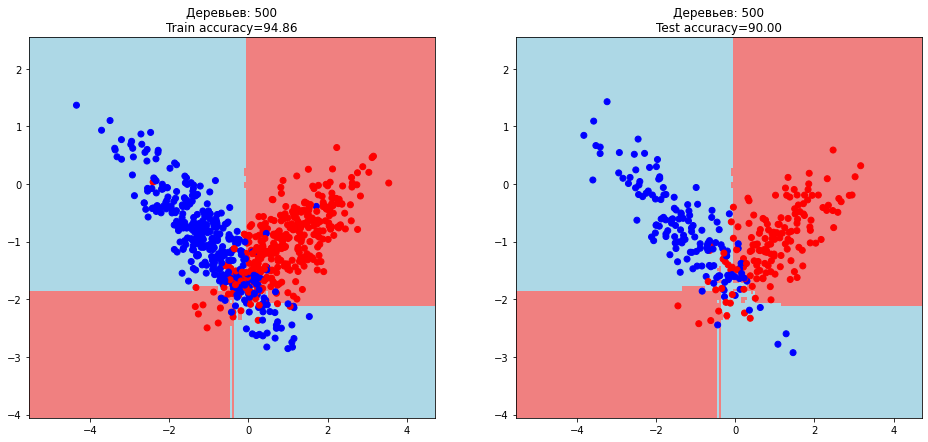

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 500)

Сведем результаты в таблицу

In [ ]:
report = pd.DataFrame(SUMMARY_DATA, columns=['n_trees', 'train_accuracy', 'test_accuracy', 'time_spent'])
report

,n_trees,train_accuracy,test_accuracy,time_spent
0,1,90.000000,84.666667,0 days 00:00:00.598021
1,3,93.142857,89.000000,0 days 00:00:01.019588
2,10,94.428571,89.333333,0 days 00:00:04.576374
3,50,94.857143,89.000000,0 days 00:00:16.185750
4,100,95.142857,89.000000,0 days 00:00:34.556437
5,500,94.857143,90.000000,0 days 00:02:51.472031


**2.** Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

---

1) Увеличение числа деревьев увеличивает сложность гиперплоскости. Но после 50 деревьев сложность визуально трудно различима.
2) Переобучаемость модели (длинные тонкие линии) уменьшается. И сходит на "нет" уже на 50 деревьях.
3) Думаю, что уже на 5 деревьях ошибки на трейне и тесте выходят на финальное значение. И следующий скачек наступает только при 500 деревьев. Но время выполния увеличивается более чем в 100 раз. И наверное на практике нет смысла гнаться за такой точностью.

**3.** Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.  

---

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

Следовательно нам понадобится запомнить индексы тех объектов, которые попали в бутстрап, чтобы эти объекты не попали в оценку качества алгоритма.

In [ ]:
# Генерация N-бутстрап выборок(модифицирована)

random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx = set() # множество для сбора индексов
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_idx.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels, b_idx)) # добавление собранных индексов к реузльтату работы функции
        
    return bootstrap

Теперь передадим эти индексы в голосование через наш лес

In [ ]:
# модифицировано
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    f_idx=[] # сбор индексов
    for b_data, b_labels, b_idx in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
        f_idx.append(b_idx)
    return forest, f_idx

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, f_idx, data, labels=None):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    # Out-of-Bag
    vote_count = 0 #считаем все голоса
    err_count = 0 #считаем ошибки
    for i in range(len(data)): #проверка индекса объекта на участие в обучении
        data_pred=[]
        for j in range(len(f_idx)):
            if i in f_idx[j]: #если использовался-пропускаем
                continue
            data_pred.append(*predict([data[j]], forest[j])) #не использовался-делаем предсказание
        if data_pred and labels is not None:
            if max(data_pred, key=data_pred.count)!=labels[i]: #проверяем на правильность
                err_count+=1
            vote_count+=1
    oob=err_count/(vote_count if vote_count != 0 else 1) 
    
        
    return voted_predictions, oob

посмотрим на результат

возьмем 50 деревьев:

In [ ]:
#обучаться будем на всей выборке
my_forest_50, f_idx = random_forest(classification_data, classification_labels, 50)

In [ ]:
answ, out_of_bag = tree_vote(my_forest_50, f_idx, classification_data, classification_labels)
print(f'Out of bag error: {out_of_bag:.2f}')

Out of bag error: 0.52


значение ошибки достаточно велико, модель в 52% случаев ошибается на объектах, не участвовавших в построении леса.

Точность ответов полученных голосованием на всех объектах:

In [ ]:
accuracy = accuracy_metric(classification_labels, answ)
accuracy

95.39999999999999

Text(0.5, 1.0, 'Деревьев: 50\n accuracy=95.40')

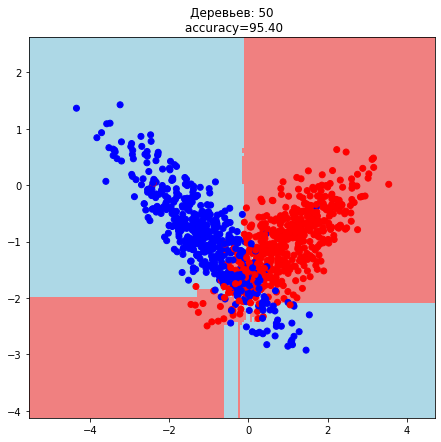

In [ ]:
plt.figure(figsize = (16, 7))
  
plt.subplot(1,2,1)

xx, yy = get_meshgrid(classification_data)
mesh_predictions_tmp, oob = tree_vote(my_forest_50, f_idx, np.c_[xx.ravel(), yy.ravel()])
mesh_predictions = np.array(mesh_predictions_tmp).reshape(xx.shape) 
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors)
plt.title(f'Деревьев: 50\n accuracy={accuracy:.2f}')


**4.** (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

---

In [ ]:
# Расчёт энтропии Шенона

def entrop(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_entrop):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entrop - p * entrop(left_labels) - (1 - p) * entrop(right_labels)

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entrop = entrop(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entrop)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index 


Вернем обратно все ранее "искаверканные" процедуры

In [ ]:
 # предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions  

def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
    return forest        

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
SUMMARY_DATA=[] 

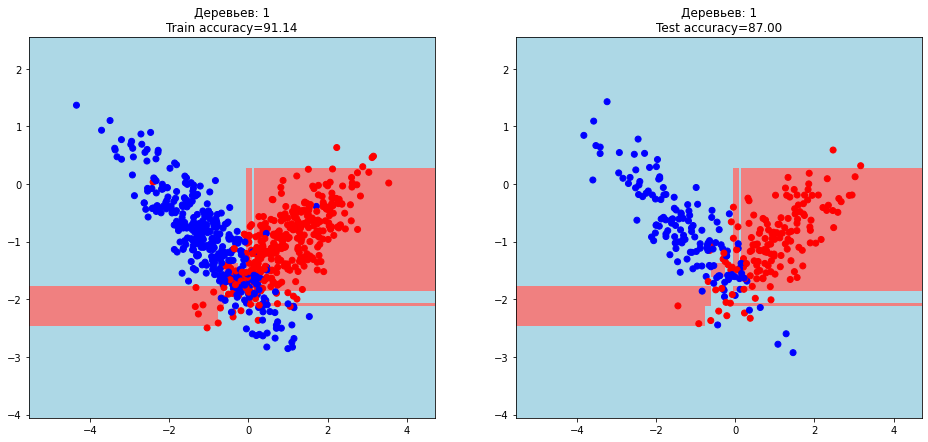

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 1)

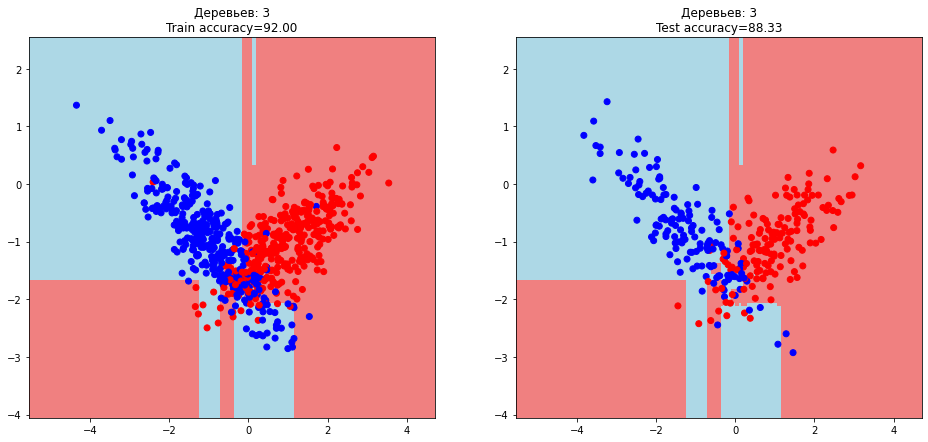

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 3)

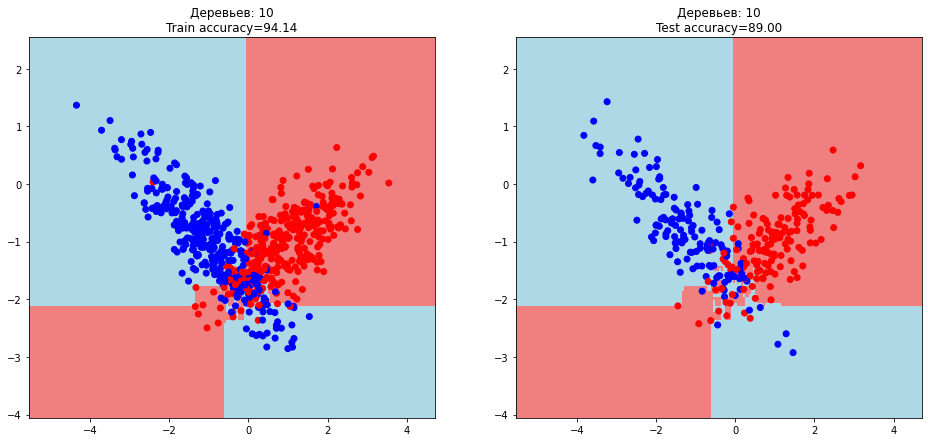

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 10)

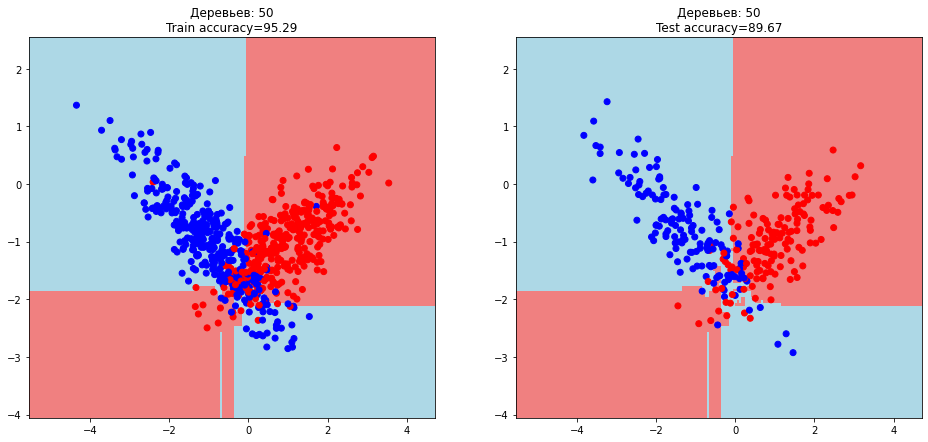

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 50)

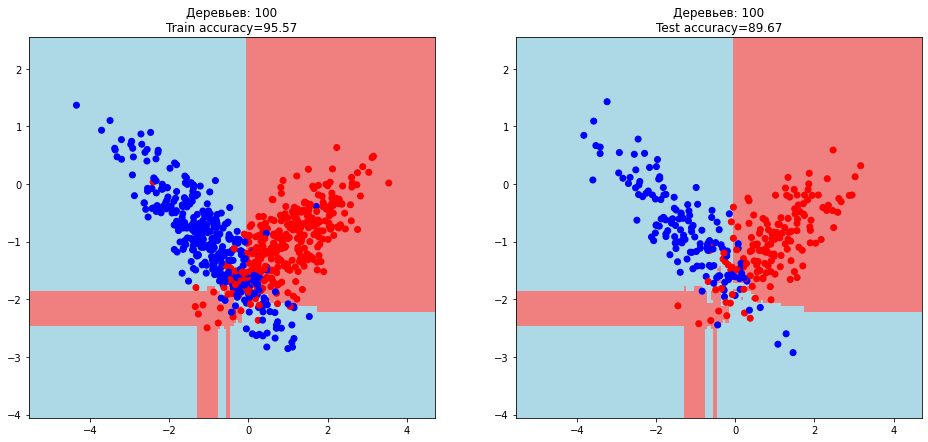

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 100)

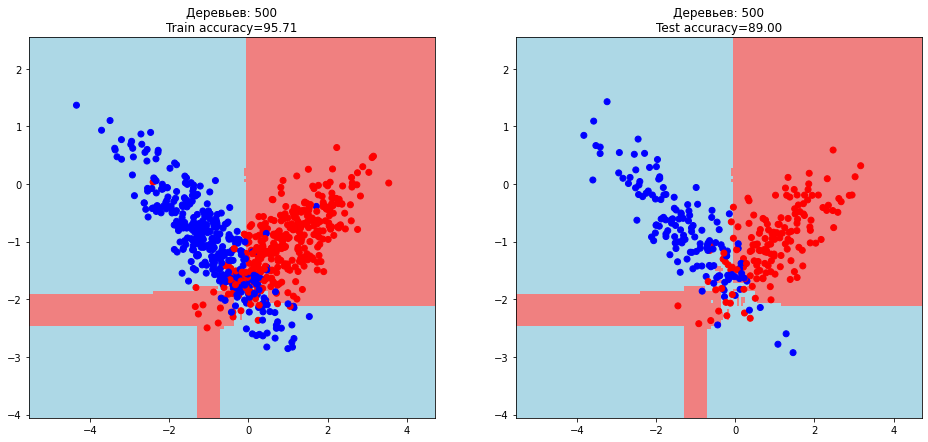

In [ ]:
make_experiment(train_data, train_labels, test_data, test_labels, 500)

In [ ]:
report=pd.DataFrame(SUMMARY_DATA, columns=['n_trees', 'train_accuracy', 'test_accuracy', 'time_spent'])
report

,n_trees,train_accuracy,test_accuracy,time_spent
0,1,91.142857,87.000000,0 days 00:00:00.567836
1,3,92.000000,88.333333,0 days 00:00:01.969227
2,10,94.142857,89.000000,0 days 00:00:03.567265
3,50,95.285714,89.666667,0 days 00:00:16.228116
4,100,95.571429,89.666667,0 days 00:00:36.135818
5,500,95.714286,89.000000,0 days 00:02:52.479785


Как и ожидалось "грандиозных" улучшений, да и вообще изменений, не наблюдается. Визуально чуть больше переобученности. Т.к. даже при большом ансамбле присутствуют токие полосы.